## Imports / Globals

In [2]:
import pickle
import pandas as pd
from os import listdir
from os.path import isfile, join
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import random
import itertools

np.random.seed(42)
random.seed(42)

In [3]:
# path = '/Users/thomas/Downloads/nturgb+d_skeletons'
path = 'D:\\Datasets\\Motion Privacy\\NTU RGB+D 120\\Skeleton Data'
X_path = 'data/X.pkl'

## Data organization

In [4]:
def load_files():
    # Read the files
    files = [f for f in listdir(path) if isfile(join(path, f))]

    # Get stats for each file based on name
    files_ = []
    for file in files:
        data = {'file': file,
                's': file[0:4],
                'c': file[4:8],
                'p': file[8:12],
                'r': file[12:16],
                'a': file[16:20]
                }
        files_.append(data)

    return files_
files_ = None

In [5]:
# Attempt to load X and Y from pickle before generating them
X = {}
try:
    print('Attempting to load X from pickle')
    with open(X_path, 'rb') as f:
        X = pickle.load(f)
    print('X loaded from pickle')
except:
    print('Could not load X and Y, generating them now')
    
    # Read the files
    files = [f for f in listdir(path) if isfile(join(path, f))]

    # Get stats for each file based on name
    files_ = []
    for file in files:
        data = {'file': file,
                's': file[0:4],
                'c': file[4:8],
                'p': file[8:12],
                'r': file[12:16],
                'a': file[16:20]
                }
        files_.append(data)

    # Generate X and Y
    for file_ in tqdm(files_, desc='Files Parsed', position=0):
        try:
            file = join(path, file_['file'])
            data = open(file, 'r')
            lines = data.readlines()
            frames_count = int(lines.pop(0).replace('\n', ''))
            file_['frames'] = frames_count
        except UnicodeDecodeError: # .DS_Store file
            print('UnicodeDecodeError: ', file)
            continue

        # Add filename as key to X
        X[file_['file']] = []

        # Skip file if 2 actors
        if lines[0].replace('\n', '') != '1': continue

        for f in tqdm(range(frames_count), desc='Frames Parsed', position=1, leave=False):
            try:
                # Get actor count
                actors = int(lines.pop(0).replace('\n', ''))
            
                # Get actor info
                t = lines.pop(0)

                # Get joint count
                joint_count = int(lines.pop(0).replace('\n', ''))

                # Get joint info
                d = []
                for j in range(joint_count):
                    joint = lines.pop(0).replace('\n', '').split(' ')
                    d.extend(joint[0:3])

                # Skip if not 25 joints
                if len(d) != 75: continue

                # Convert to numpy array
                d = np.array(d)

                # Append to X and Y
                X[file_['file']].append(d)
            except:
                break
        
        # Convert to numpy array
        X[file_['file']] = np.array(X[file_['file']], dtype=np.float16)

        # Pad X size to 300 frames (300 is max frames in dataset)
        X[file_['file']] = np.pad(X[file_['file']], ((0, 300-X[file_['file']].shape[0]), (0, 0)), 'constant')


    print('X Generated, saving to pickle...')

    # Save the data
    with open(X_path, 'wb') as f:
        pickle.dump(X, f)

    print('X Saved to pickle')


Attempting to load X from pickle
X loaded from pickle


## Data Generators

In [6]:
same_samples_per_actor = 250
diff_samples_per_actor = 250

def data_generator_per_actor(X, same_samples_per_actor=1000, diff_samples_per_actor=1000, train=True):
    actor_data = {}
    for file in X:
        actor = int(file[9:12])
        action = int(file[17:20])

        if train: 
            if action > 60:
                continue
        else:
            if action <= 60:
                continue

        if actor not in actor_data:
            actor_data[actor] = []
        if len(X[file]) == 0:
            continue
        actor_data[actor].append(X[file])

    actor_keys = list(actor_data.keys())

    samples = []
    for actor in tqdm(actor_keys):
        for _ in range(same_samples_per_actor):
            same_video1 = random.choice(actor_data[actor])
            same_video2 = random.choice(actor_data[actor])
            samples.append((np.array([same_video1, same_video2]).astype(np.float32), 1))

        for _ in range(diff_samples_per_actor):
            while True:
                diff_actor = random.choice(actor_keys)
                if diff_actor != actor:
                    break
            same_video1 = random.choice(actor_data[actor])
            diff_video = random.choice(actor_data[diff_actor])
            samples.append((np.array([same_video1, diff_video]).astype(np.float32), 0))

        random.shuffle(samples)

    return np.array(samples)


train_gen = data_generator_per_actor(X, same_samples_per_actor, diff_samples_per_actor, train=True)
val_gen = data_generator_per_actor(X, int(float(same_samples_per_actor)/2), int(float(diff_samples_per_actor)/2), train=False)
test_gen = data_generator_per_actor(X, same_samples_per_actor, diff_samples_per_actor, train=False)

  0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\Carrt\AppData\Local\Temp\ipykernel_18888\391684319.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(samples)


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

In [7]:
len(train_gen), len(val_gen), len(test_gen)

(20000, 17250, 34500)

## SGN

All code in this section is adapted from Microsoft's SGN. [Github](https://github.com/microsoft/SGN)

In [8]:
# Hyperparameters/Tuning Parameters
dataset='NTU'
batch_size=32
max_epochs=10000
lr=1e-3
weight_decay=1e-4
do_train=1
seg=20
loss_lambda = 1e-5
# load_model='best_model'
load_model=False

In [9]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from model import SGN
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# Tweaks for Linkage Attack
class SGN_Linkage_Attack(nn.Module):
    def __init__(self, model_a, model_b, output_size):
        super(SGN_Linkage_Attack, self).__init__()
        self.model_a = model_a
        self.model_b = model_b
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, output_size)
        pretrained = torch.load('C:\\Users\\Carrt\\OneDrive\\Code\\Motion Privacy\\Attacking Models\\SGN Attack Model\\results\\NTU\\SGN\\0_best.pth')['state_dict']
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        self.model_a.load_state_dict(pretrained)
        self.model_b.load_state_dict(pretrained)
        
        freeze = False
        if freeze:
            num_layers_to_unfreeze = -1

            if num_layers_to_unfreeze > 0:
            
                for i, (name, param) in enumerate(self.model_a.named_parameters()):
                    if i >= len(list(self.model_a.named_parameters())) - num_layers_to_unfreeze:
                        param.requires_grad = True
                    else:
                        param.requires_grad = False
                        
                for i, (name, param) in enumerate(self.model_b.named_parameters()):
                    if i >= len(list(self.model_b.named_parameters())) - num_layers_to_unfreeze:
                        param.requires_grad = True
                    else:
                        param.requires_grad = False
            else:
                for param in self.model_a.parameters():
                    param.requires_grad = False
                    
                for param in self.model_b.parameters():
                    param.requires_grad = False

    def forward(self, x_a, x_b):
        a_out = self.model_a(x_a).cuda()
        b_out = self.model_b(x_b).cuda()
        out = torch.cat((a_out, b_out), dim=1).unsqueeze(2)
        out = F.relu(self.bn1(self.conv1(out)))
        out = self.dropout1(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.bn2(self.fc1(out)))
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.dropout3(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        return out
    
    def print_weights(self):
        print('FC Weights: ', self.fc[0].weight)
        print('FC Bias: ', self.fc[0].bias)
        print('Model A state_dict:', self.model_a.state_dict())
        print('Model B state_dict:', self.model_b.state_dict())

class SGN_Linkage_Attack_Simple(nn.Module):
    def __init__(self, model_a, model_b, output_size):
        super(SGN_Linkage_Attack_Simple, self).__init__()
        self.model_a = model_a
        self.model_b = model_b
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, output_size)
        pretrained = torch.load('C:\\Users\\Carrt\\OneDrive\\Code\\Motion Privacy\\Attacking Models\\SGN Attack Model\\results\\NTU\\SGN\\0_best.pth')['state_dict']
        del pretrained['fc.weight']
        del pretrained['fc.bias']
        self.model_a.load_state_dict(pretrained)
        self.model_b.load_state_dict(pretrained)
        
        freeze = True
        if freeze:
            for i, (name, param) in enumerate(self.model_a.named_parameters()):
                param.requires_grad = False                    
            for i, (name, param) in enumerate(self.model_b.named_parameters()):
                param.requires_grad = False

    def forward(self, x_a, x_b):
        a_out = self.model_a(x_a).cuda()
        b_out = self.model_b(x_b).cuda()
        out = torch.cat((a_out, b_out), dim=1)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out
    
    def print_weights(self):
        print('FC Weights: ', self.fc[0].weight)
        print('FC Bias: ', self.fc[0].bias)
        print('Model A state_dict:', self.model_a.state_dict())
        print('Model B state_dict:', self.model_b.state_dict())

class SGN_Linkage_Dataset(Dataset):
    def __init__(self, data_gen, seg=20):
        self.data_gen = data_gen
        self.seg = seg

    def __len__(self):
        return len(self.data_gen)

    def __getitem__(self, idx):
        # x, y = next(self.data_gen)
        x, y = self.data_gen[idx]
        x_a, x_b = self.preprocess(x)
        return x_a, x_b, y

    def preprocess(self, x):
        x_a = x[0]
        x_b = x[1]

        x_a = self.tolist_fix([x_a])
        x_a = torch.tensor(x_a).cuda()
        x_b = self.tolist_fix([x_b])
        x_b = torch.tensor(x_b).cuda()

        # epsilon = 1e-8
        # x_a = (x_a - x_a.mean(dim=1, keepdim=True)) / (x_a.std(dim=1, keepdim=True) + epsilon)
        # x_b = (x_b - x_b.mean(dim=1, keepdim=True)) / (x_b.std(dim=1, keepdim=True) + epsilon)

        x_a = x_a.squeeze(0)
        x_b = x_b.squeeze(0)

        return x_a, x_b

    def tolist_fix(self, joints, train=1):
        seqs = []

        for idx, seq in enumerate(joints):
            zero_row = []
            for i in range(len(seq)):
                if np.array_equal(seq[i, :], np.zeros(75)):
                    zero_row.append(i)

            seq = np.delete(seq, zero_row, axis=0)
            seqs = self.sub_seq(seqs, seq, train=train)

        return seqs

    def sub_seq(self, seqs, seq, train=1):
        group = self.seg

        if seq.shape[0] < self.seg:
            pad = np.zeros(
                (self.seg - seq.shape[0], seq.shape[1])).astype(np.float32)
            seq = np.concatenate([seq, pad], axis=0)

        ave_duration = seq.shape[0] // group

        if train == 1:
            offsets = np.multiply(
                list(range(group)), ave_duration) + np.random.randint(ave_duration, size=group)
            seq = seq[offsets]
            seqs.append(seq)

        return seqs

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            target = target.long()  # Convert target tensor to long
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

def evaluate_metrics(model, criterion, data_loader):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        # for x_a, x_b, targets in tqdm(data_loader, leave=False, desc='Testing', position=1):
        for x_a, x_b, targets in data_loader:
            x_a, x_b, targets = x_a.cuda(), x_b.cuda(), targets.float().cuda()

            outputs = model(x_a, x_b)
            loss = criterion(outputs.squeeze(), targets)

            # L1 regularization
            # l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)  # Compute the L1 norm for trainable parameters
            # loss = loss + loss_lambda * l1_norm

            total_loss += loss.item() * targets.size(0)
            total_samples += targets.size(0)

            predictions = (outputs > 0.5).long().squeeze()  # Convert output to binary format
            all_targets.extend(targets.tolist())
            all_predictions.extend(predictions.tolist())

    # Calculate metrics
    loss = total_loss / total_samples
    accuracy = accuracy_score(all_targets, all_predictions)
    cm = confusion_matrix(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='binary', zero_division=1)
    
    return accuracy, loss, cm, precision, recall, f1

def test(model, data_loader):
    model.eval()
    total_samples = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for x_a, x_b, targets in tqdm(data_loader, desc='Testing'):
            x_a, x_b, targets = x_a.cuda(), x_b.cuda(), targets.float().cuda()

            outputs = model(x_a, x_b)
            total_samples += targets.size(0)

            predictions = (outputs > 0.5).long().squeeze()  # Convert output to binary format
            all_targets.extend(targets.tolist())
            all_predictions.extend(predictions.tolist())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    cm = confusion_matrix(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='binary', zero_division=1)
    
    return accuracy, cm, precision, recall, f1


In [23]:
def main(do_train = True, patience = 16):
    # Initiate the two SGN models
    num_classes = 1 # Is the same or not the same
    SGN_Encoder1 = SGN(num_classes, dataset, seg, batch_size, do_train).cuda()
    SGN_Encoder2 = SGN(num_classes, dataset, seg, batch_size, do_train).cuda()
    
    # Combine the two SGN Models
    model = SGN_Linkage_Attack(SGN_Encoder1, SGN_Encoder2, num_classes).cuda()

    train_dataset, val_dataset, test_dataset = SGN_Linkage_Dataset(train_gen), SGN_Linkage_Dataset(val_gen), SGN_Linkage_Dataset(test_gen)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Set up checkpoint director
    checkpoint_dir = 'models'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Load the model if specified
    if load_model:
        # Load the model
        model.load_state_dict(torch.load(f'{checkpoint_dir}/{load_model}.pt'))
        print('Model loaded')

    # Initialize variables for tracking loss
    best_loss = float('inf')
    best_epoch = 0
    train_losses = []
    val_losses = []

    # Train the model
    # criterion = LabelSmoothingLoss(num_classes, smoothing=0.1).cuda()
    criterion = nn.BCELoss().cuda()
    # criterion = FocalLoss().cuda()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)

    # Scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=int(patience/2), verbose=True)
    early_stopping_counter = 0

    if do_train:
        for epoch in tqdm(range(max_epochs), desc='Epochs'):
            # Train
            model.train(True)
            total_train_loss = 0
            train_targets = []
            train_predictions = []
            # for i, (x_a, x_b, y) in enumerate(tqdm(train_loader, leave=True, desc='Training Batch', position=1)):
            for i, (x_a, x_b, y) in enumerate(train_loader):
                x_a = x_a.cuda()
                x_b = x_b.cuda()
                y = y.float().cuda()
                
                output = model(x_a, x_b)
                loss = criterion(output.squeeze(), y)

                # L1 regularization
                # l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)  # Compute the L1 norm for trainable parameters
                # loss = loss + loss_lambda * l1_norm
    
                optimizer.zero_grad()
                total_train_loss += loss.item()  # Update total training loss
                loss.backward()

                predictions = (output > 0.5).long().squeeze()  # Convert outputs to binary format
                train_targets.extend(y.tolist())
                train_predictions.extend(predictions.tolist())
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

                optimizer.step()

            avg_train_loss = total_train_loss / len(train_loader)  # Calculate average training loss

            # Evaluate
            val_acc, val_loss, _, val_precision, val_recall, val_f1 = evaluate_metrics(model, criterion, validation_loader)
            train_acc = accuracy_score(train_targets, train_predictions)
            train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(train_targets, train_predictions, average='binary')
            print(f'Epoch {epoch+1}\nTraining Loss: {avg_train_loss}, Training Accuracy: {train_acc}, Train Precision: {train_precision}, Train Recall: {train_recall}, Train F1: {train_f1}\nValidation Loss: {val_loss}, Validation Accuracy: {val_acc}, Validation Precision: {val_precision}, Validation Recall: {val_recall}, Validation F1: {val_f1}')
            train_losses.append(avg_train_loss)
            val_losses.append(val_loss)

            # Save the best model
            if val_loss < best_loss:
                best_loss = val_loss
                best_epoch = epoch
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pt'))
                print(f'New best validation loss, checkpoint saved')
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            
            if early_stopping_counter >= patience:
                print('Early stopping')
                break
            
            scheduler.step(val_loss)

    # Load the best model
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pt')))

    # Evaluate the model
    accuracy, loss, cm, precision, recall, f1 = evaluate_metrics(model, criterion, test_loader)
    print(f'Accuracy: {accuracy}')
    print(f'Loss: {loss}')
    print(f'Confusion Matrix: {cm}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

    return train_losses, val_losses

tl, vl = main(do_train=True)

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1
Training Loss: 0.6244159667015076, Training Accuracy: 0.65225, Train Precision: 0.6310579323405354, Train Recall: 0.7331, Train F1: 0.6782624786048017
Validation Loss: 0.6809374739818538, Validation Accuracy: 0.5986201298701299, Validation Precision: 0.5721680101824353, Validation Recall: 0.7818877551020408, Validation F1: 0.6607869077367828
New best validation loss, checkpoint saved
Epoch 2
Training Loss: 0.576109285736084, Training Accuracy: 0.70435, Train Precision: 0.6734867136429239, Train Recall: 0.7933, Train F1: 0.7284999311263144
Validation Loss: 0.6660064510821412, Validation Accuracy: 0.6324791280148423, Validation Precision: 0.6068056464429279, Validation Recall: 0.7526669758812616, Validation F1: 0.6719113917499094
New best validation loss, checkpoint saved
Epoch 3
Training Loss: 0.5551592101573944, Training Accuracy: 0.722, Train Precision: 0.6905252317198765, Train Recall: 0.8046, Train F1: 0.7432107888416775
Validation Loss: 0.6411251573925337, Validation Accura

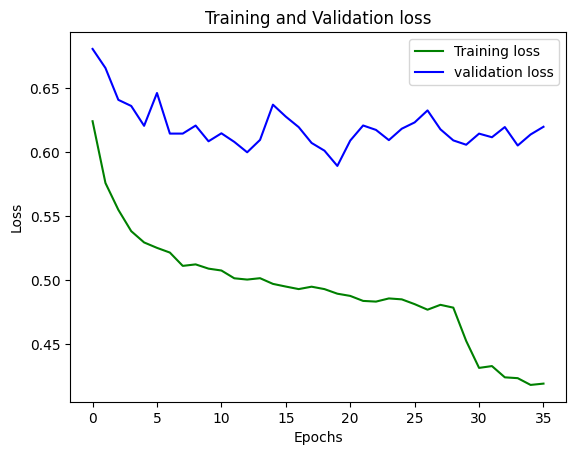

In [24]:
import matplotlib.pyplot as plt
plt.plot(tl, 'g', label='Training loss')
plt.plot(vl, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test Model

In [24]:
def anonymizer_to_sgn(t, max_frames=300):
    # (300, 150)
    # [x:0,y:1,z:2][300][joints][actors]
    xyz,frames,joints,actors = t.shape
    # transpose to make loop simple
    # [frame][actors][joints][xyz]
    t = t.transpose(1,3,2,0)
    # make empty array
    frames = []
    
    joints_per_frame = xyz*joints*actors
    
    # crazy loop
    for frame in t:
        f = []
        for actor in frame:
            for joint in actor:
                for xyz in joint:
                    f.append(xyz)
        
        # Pad 0's to 150 joints (2 actors)
        if len(f) < joints_per_frame:
            f = np.pad(f, (0, joints_per_frame-len(f)), 'constant')
            
        frames.append(f)
        
    # to numpy array
    X = np.array(frames, dtype=np.float32)
    
    if X.shape[0] < max_frames:
        X = np.pad(X, ((0, max_frames-X.shape[0]), (0, 0)), 'constant')
        
    return X

In [40]:
# Classical MR
# x_pkl = 'C:\\Users\\Carrt\\OneDrive\\Code\\Motion Privacy\\Defense Models\\Mean Skeleton\\X_FileNameKey_SingleActor.pkl'
# from_moon = False

# Moon ResNet
# x_pkl = 'C:\\Users\\Carrt\\OneDrive\\Code\\Motion Privacy\\External Repositories\\Skeleton-anonymization\\X_resnet_file.pkl'
# from_moon = True

# Moon UNet
x_pkl = 'C:\\Users\\Carrt\\OneDrive\\Code\\Motion Privacy\\External Repositories\\Skeleton-anonymization\\X_unet_file.pkl'
from_moon = True

with open(x_pkl, 'rb') as f:
    test_x = pickle.load(f)

val_files = 'data/ntu120_no_dupe_actors.pkl'
# val_files = 'data/ntu120.pkl'

with open(val_files, 'rb') as f:
    files_ = pickle.load(f)

to_del = []
for file in test_x:
    if file not in files_:
        to_del.append(file)

for file in to_del:
    del test_x[file]

if from_moon:
    test_x = {k: v[0] for k, v in test_x.items()}

    for file in test_x:
        test_x[file] = anonymizer_to_sgn(test_x[file])[:, :75]

In [41]:
diff_samples_per_actor = 250
same_samples_per_actor = 250
test_x_gen = data_generator_per_actor(test_x, same_samples_per_actor, diff_samples_per_actor, train=False)

  0%|          | 0/69 [00:00<?, ?it/s]

C:\Users\Carrt\AppData\Local\Temp\ipykernel_18888\391684319.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(samples)


In [43]:
# model_save = 'models/best_model.pt'
# model_save = 'models/2unfrozen_67acc.pt'
model_save = 'models/frozen_65.7acc.pt'
# model_save = 'models/unfrozen_69.5acc.pt'

num_classes = 1

SGN_Encoder1 = SGN(num_classes, dataset, seg, batch_size, do_train).cuda()
SGN_Encoder2 = SGN(num_classes, dataset, seg, batch_size, do_train).cuda()
model = SGN_Linkage_Attack(SGN_Encoder1, SGN_Encoder2, num_classes).cuda()

model.load_state_dict(torch.load(model_save))

dataset = SGN_Linkage_Dataset(test_x_gen)
dl = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

accuracy, cm, precision, recall, f1 = test(model, dl)
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{cm}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

# Optional: Test on raw data
test_raw = False
if test_raw:
    raw_dataset = SGN_Linkage_Dataset(test_gen)
    dl2 = DataLoader(raw_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    accuracy, cm, precision, recall, f1 = test(model, dl2)
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix:\n{cm}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

Testing:   0%|          | 0/1078 [00:00<?, ?it/s]

Accuracy: 0.5002319109461967
Confusion Matrix:
[[   51 17195]
 [   45 17205]]
Precision: 0.5001453488372093
Recall: 0.9973913043478261
F1: 0.66621490803485
